In [1]:
!pip install tflearn
!pip install pydrive
!pip install matplotlib


    100% |████████████████████████████████| 102kB 3.6MB/s 
  Running setup.py bdist_wheel for tflearn ... - \ done
  Stored in directory: /content/.cache/pip/wheels/fb/06/72/0478c938ca315c6fddcce8233b80ec91a115ce4496a27e8c90
Successfully built tflearn
    100% |████████████████████████████████| 993kB 1.2MB/s 
  Running setup.py bdist_wheel for pydrive ... - done
  Stored in directory: /content/.cache/pip/wheels/ea/bd/b1/14e948c56cce2c7ac1589346cb54d7efb659fa2ddfa6abba88
Successfully built pydrive


In [0]:
from __future__ import division, print_function, absolute_import

import pickle
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tflearn
from tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [4]:
from pydrive.drive import GoogleDrive

drive = GoogleDrive(gauth) # Create GoogleDrive instance with authenticated GoogleAuth instance

# Auto-iterate through all files in the root folder.
file_list = drive.ListFile({'q': "'1vQhQXjy4X9woILOTXeY3C-tz14xJkBQE' in parents and trashed=false"}).GetList()
for file1 in file_list:
  if file1['title'] == 'test.pkl':
     TESTPIK = file1['id']
     print('title: %s, id: %s' % (file1['title'], file1['id']))


title: test.pkl, id: 1gSKWAsH9YND3Y3_vNrXeXa-KRiPEGqBS


In [0]:
X_test = []
Y_test = []

label_pairs ={
    'adho_mukha_svanasana':1,
    'bharadvajasana':2,
    'pasasana':3,
    'salamba_sarvangasana':4,
    'salamba_sirsasana':5,
    'virabhadrasana_I':6,
    'virabhadrasana_II':7,
    'virabhadrasana_III':8
}

In [0]:
testFile = drive.CreateFile({'id': TESTPIK}).GetContentFile('test.pkl')

In [7]:
X_type = 'float64'

with open('test.pkl', "rb") as f:
    while True :
        try:
            record=pickle.load(f)
            X_test.append(record[0].astype(X_type))
            Y_test.append(label_pairs[record[1]])
        except EOFError:
            print('processing done!')
            break
            
print ("Test Data Size :" , len(X_test))


processing done!
Test Data Size : 265


In [8]:
#Define Model
Y_test = to_categorical(Y_test, 9)

from __future__ import division, print_function, absolute_import

import tflearn

# Real-time data preprocessing - normalize the data
img_prep = ImagePreprocessing()
img_prep.add_featurewise_zero_center()
img_prep.add_featurewise_stdnorm()

# Real-time data augmentation
# Create extra synthetic training data by flipping, rotating and blurring images
img_aug = ImageAugmentation()
#img_aug.add_random_flip_leftright()
img_aug.add_random_rotation(max_angle=25.)
# img_aug.add_random_crop((64, 64))
# mg_aug.add_random_blur (sigma_max=5.0)

# Define our network architecture:

# Input is a 64x64 image with 3 color channels (red, green and blue)
network = input_data(shape=[None, 64, 64, 3],
                     data_preprocessing=img_prep,
                     data_augmentation=img_aug)

# Step 1: Convolution
network = conv_2d(network, 64, 3, activation='relu')

# Step 2: Max pooling
network = max_pool_2d(network, 2)

# Step 3: Convolution again
network = conv_2d(network, 128, 3, activation='relu')

# Step 4: Convolution yet again
network = conv_2d(network, 128, 3, activation='relu')

# Step 5: Max pooling again
network = max_pool_2d(network, 2)

# Step 6: Convolution yet again
network = conv_2d(network, 128, 3, activation='relu')

# Step 7: Max pooling again
# network = max_pool_2d(network, 2)

# Step 8: Fully-connected 512 node neural network
network = fully_connected(network, 512, activation='relu')

# Step 9: Dropout - throw away some data randomly during training to prevent over-fitting
network = dropout(network, 0.5)

# Step 10: Fully-connected neural network with two outputs (0=isn't a bird, 1=is a bird) to make the final prediction
network = fully_connected(network, 9, activation='softmax')

# Tell tflearn how we want to train the network
network = regression(network, optimizer='adam',
                     loss='categorical_crossentropy',
                     learning_rate=0.001)


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


In [0]:
model_name = "tflearn-CIFAR_v0.3.tfl"
# Auto-iterate through all files in the root folder.
model_parentfolder_id="1Ay8W74_15gHTpEz-SARe-mxXBE-yTKoe"
file_list = drive.ListFile({'q': "'{parent_id}'".format(parent_id=model_parentfolder_id) + " in parents and trashed=false"}).GetList()
for file1 in file_list:
  if file1['title'] == model_name :
    model_dir = drive.ListFile({'q': "'{folderid}' in parents and trashed=false".format(folderid=file1['id'])}).GetList()
    for file2 in model_dir:
      drive.CreateFile({'id': file2['id']}).GetContentFile(file2['title']) 
   

In [0]:
model = tflearn.DNN(network)

In [11]:
model.load(model_name)

INFO:tensorflow:Restoring parameters from /content/tflearn-CIFAR_v0.3.tfl


In [0]:
new_test_images_and_labels = list(zip(X_test, Y_test))

In [13]:
#Predicting

correct_count = 0
wrong_count = 0
correct_indices = []
wrong_indices = []
preds = []
labels = []
total_predict_time = 0;

for (image, label) in (new_test_images_and_labels):
    imagedata = image[np.newaxis, :, :]
    predict_start_time = time.time()
    pred = model.predict(imagedata)
    total_predict_time=total_predict_time+(time.time()-predict_start_time)
    pred = pred[0].argmax(axis=0)
    label = label.argmax(axis=0)
    #print("Pred: {pred} Actual:{label}".format(pred=pred, label=label) )
    #print(int(pred))
    #print(int(label))
    preds = np.append(preds,pred)
    labels = np.append(labels,label)
    if int(pred) == int(label) :
        correct_count=correct_count+1
        #correct_indices = np.append(correct_indices)
    else :
        wrong_count=wrong_count+1
        #wrong_indices = np.append(wrong_indices)
        #mistakes = list.append(mistakes,imagedata[0],label,pred])
        #plt.imshow(imagedata[0].astype('uint8'),aspect="auto")
        #plt.title("Pred: {pred} Actual:{label}".format(pred=pred, label=label))
        #plt.show()
        #input("Press Enter to continue...")

accuracy=correct_count/(correct_count+wrong_count)
print(accuracy)
print(correct_count)
print(wrong_count)
print("Total Prediction Time :" + str(total_predict_time))


0.7962264150943397
211
54
Total Prediction Time :1.759268045425415


[[24  2  0  0  0  1  0  1]
 [ 0 25  1  0  2  2  2  1]
 [ 1  1 19  0  1  0  3  1]
 [ 0  0  1 22  1  2  2  1]
 [ 0  1  0  2 31  3  1  5]
 [ 0  0  2  0  3 27  8  0]
 [ 0  1  0  0  0  0 37  0]
 [ 1  0  0  0  0  0  1 26]]
Confusion matrix, without normalization
[[24  2  0  0  0  1  0  1]
 [ 0 25  1  0  2  2  2  1]
 [ 1  1 19  0  1  0  3  1]
 [ 0  0  1 22  1  2  2  1]
 [ 0  1  0  2 31  3  1  5]
 [ 0  0  2  0  3 27  8  0]
 [ 0  1  0  0  0  0 37  0]
 [ 1  0  0  0  0  0  1 26]]
Normalized confusion matrix
[[0.85714286 0.07142857 0.         0.         0.         0.03571429
  0.         0.03571429]
 [0.         0.75757576 0.03030303 0.         0.06060606 0.06060606
  0.06060606 0.03030303]
 [0.03846154 0.03846154 0.73076923 0.         0.03846154 0.
  0.11538462 0.03846154]
 [0.         0.         0.03448276 0.75862069 0.03448276 0.06896552
  0.06896552 0.03448276]
 [0.         0.02325581 0.         0.04651163 0.72093023 0.06976744
  0.02325581 0.11627907]
 [0.         0.         0.05       0.    

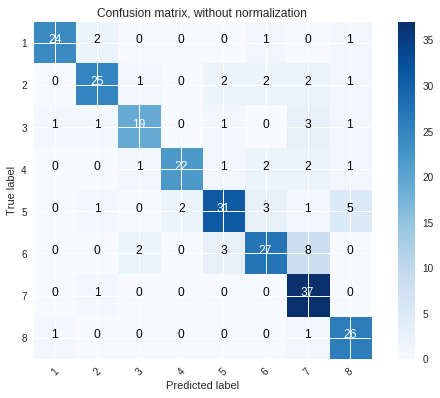

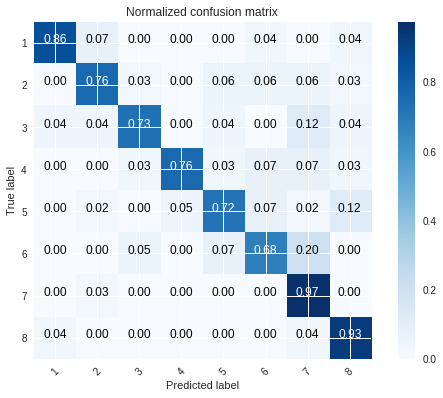

In [14]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
conf_mat = np.matrix(tf.confusion_matrix(labels,preds,num_classes=8,dtype=tf.int32))
conf_mat = confusion_matrix(labels,preds)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
np.set_printoptions(threshold=np.nan)
class_names=['1','2','3','4','5','6','7','8']
print(conf_mat)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()